<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/Random_VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [60]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install numpy
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-aer

In [61]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-skku/hackathon-2024/hackathon',
    token='24ce54238a7bb29fe5e3eb450acefed2444169ce5e525f08f9515676b1cf257ea65b85895d4157a30359eb3d9a4aab9873008d7edf6ff177ed29015e625e4ad6'
)

In [62]:
backend = AerSimulator()
print(backend)

AerSimulator('aer_simulator')


In [63]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

In [64]:
num_qubits = 5

# 2. Classical Shadow (Randomized Unitary Gates)

In [100]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch

from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

In [101]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [102]:
# Ansatz for VQE

def circuit_base(params, num_qubits):

  ansatz = QuantumCircuit(num_qubits)
  #params = ParameterVector("theta", length=9)
  it = iter(params)
  ansatz.h(range(0,5))

  ansatz.barrier()

  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.rz(next(it), 1)
  ansatz.rz(next(it), 3)
  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)
  ansatz.rz(next(it), 2)
  ansatz.rz(next(it), 4)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)

  ansatz.barrier()

  ansatz.rx(next(it), 0)
  ansatz.rx(next(it), 1)
  ansatz.rx(next(it), 2)
  ansatz.rx(next(it), 3)
  ansatz.rx(next(it), 4)

  return ansatz

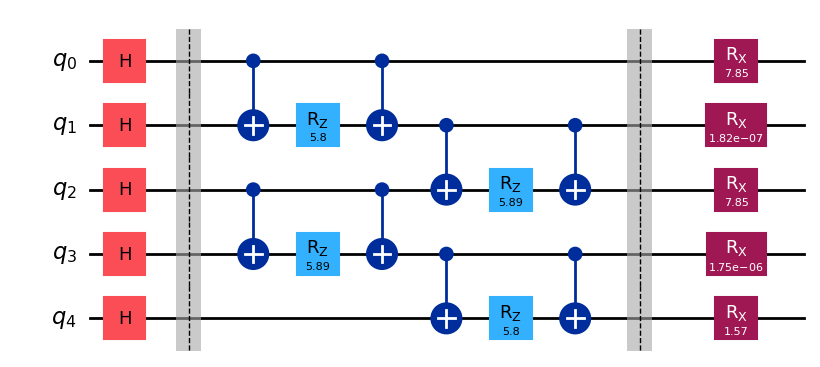

In [112]:
params = [5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00,
             1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]
qc = circuit_base(params, num_qubits)

%matplotlib inline

qc.draw("mpl")

In [104]:
def generate_pauli_string(location, pauli, num_qubits):
    string = ["I"] * num_qubits
    for i, loc in enumerate(location):
        string[num_qubits-loc-1] = pauli[i]

    result = ''.join(char for char in string)

    return result

In [109]:
def calculate_classical_shadow(circuit, shadow_size, backend):
    num_qubits = circuit.num_qubits

    unitary_ensemble = ["X", "Y", "Z"]

    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))

    pm = generate_preset_pass_manager(backend = backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    circuits = [isa_circuit] * shadow_size

    obs_list = []

    for ns in range(shadow_size):
        obs = SparsePauliOp(generate_pauli_string(range(num_qubits),[unitary_ensemble[int(unitary_ids[ns, i])] for i in range(num_qubits)],num_qubits)).apply_layout(isa_circuit.layout)
        obs_list.append(obs)


    max_circuits = 1000
    all_partitioned_circuits = []
    all_partitioned_obs = []
    for i in range(0, len(circuits), max_circuits):
        all_partitioned_circuits.append(circuits[i : i + max_circuits])
        all_partitioned_obs.append(obs_list[i:i+max_circuits])

    jobs = []


    with Batch(backend=backend) as batch:
        estimator = Estimator(batch)
        for job_idx, (partitioned_circuits, partitioned_obs) in enumerate(zip(all_partitioned_circuits, all_partitioned_obs)):
            print("Job Running"+ " " + str(job_idx))
            pub = [(circuit, obs) for circuit, obs in zip(partitioned_circuits, partitioned_obs)]
            job = estimator.run(pub)
            result = job.result()
            print("Job Run" + " " + str(job_idx) )
            for idx, pub_result in enumerate(result):
                exp_val = pub_result.data.evs
                outcomes[job_idx*max_circuits + idx :] = exp_val
            jobs.append(job)
            job.status()


    return (outcomes, unitary_ids)

In [106]:
list_of_observables = [SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)] + [SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)]
print(list_of_observables)

[SparsePauliOp(['IIIZZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['ZZIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIX'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIXI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIXII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IXIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['XIIII'],
              coeffs=[1.+0.j])]


In [113]:
def estimate_shadow_observable(shadow, observable, k=10):
    """
    Adapted from https://github.com/momohuang/predicting-quantum-properties
    Calculate the estimator E[O] = median(Tr{rho_{(k)} O}) where rho_(k)) is set of k
    snapshots in the shadow. Use median of means to ameliorate the effects of outliers.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        observable (qml.Observable): Single PennyLane observable consisting of single Pauli
            operators e.g. qml.PauliX(0) @ qml.PauliY(1).
        k (int): number of splits in the median of means estimator.

    Returns:
        Scalar corresponding to the estimate of the observable.
    """
    shadow_size, num_qubits = shadow[0].shape



    def find_not_I(observable):
        not_I = []
        string = observable.to_list(array=True)[0][0]
        for i, c in enumerate(string):
            if c != "I":
                not_I.append((num_qubits-i-1,c))
        return not_I



    map_name_to_int = {"X": 0, "Y": 1, "Z": 2}
    target_obs, target_locs = np.array([map_name_to_int[tuple[1]] for tuple in find_not_I(observable=observable)]), np.array([tuple[0] for tuple in find_not_I(observable=observable)])



    # classical values
    b_lists, obs_lists = shadow
    means = []

    # loop over the splits of the shadow:
    for i in range(0, shadow_size, shadow_size // k):

        # assign the splits temporarily
        b_lists_k, obs_lists_k = (
            b_lists[i : i + shadow_size // k],
            obs_lists[i : i + shadow_size // k],
        )

        # find the exact matches for the observable of interest at the specified locations
        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)

        # catch the edge case where there is no match in the chunk
        if sum(indices) > 0:
            # take the product and sum
            product = np.prod(b_lists_k[indices][:, target_locs], axis=1)
            means.append(np.sum(product) / sum(indices))
        else:
            means.append(0)

    return np.median(means)

In [ ]:
# make a array with exponential values
shadow_sizes = [1000, 2000, 3000, 4000, 5000]
estimates = []

#params = ParameterVector("theta", length=9)
circuit = circuit_base(params, num_qubits=num_qubits)

for shadow_size in shadow_sizes:
    shadow = calculate_classical_shadow(circuit, int(shadow_size), backend)
    # shadow = calculate_classical_shadow(circuit, int(shadow_size), backend)
    estimates.append([estimate_shadow_observable(shadow, o) for o in list_of_observables])

Job Running 0
Job Run 0
Job Running 0
Job Run 0
Job Running 1
Job Run 1
Job Running 0
Job Run 0
Job Running 1
Job Run 1
Job Running 2
Job Run 2
Job Running 0
Job Run 0
Job Running 1
Job Run 1
Job Running 2
Job Run 2
Job Running 3
Job Run 3
Job Running 0
Job Run 0
Job Running 1
Job Run 1
Job Running 2
Job Run 2
Job Running 3


In [ ]:
estimates